### Testing mulitple simple GNNs

#### Installations

In [ ]:
%pip install -r ../../requirements.txt

In [63]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Imports

In [2]:
# general
import pathlib
import os
import sys
from collections import defaultdict
from tabulate import tabulate
import matplotlib.pyplot as plt
# for py2neo and utils
from py2neo import Graph, Relationship
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

# for PyG
import torch
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.nn import to_hetero
import torch.nn.functional as F
from utils_draft.pyg import load_node, load_edge, SequenceEncoder, IdentityEncoder, ListEncoder
from torch.nn import Linear, LazyLinear
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv, TransformerConv, GraphConv

#### Connecting to the existing neo4j instance

In [3]:
graph = Graph(
    "bolt://localhost:7687",
    auth=("neo4j", "admin"),
)

#### Observing the pre-stored graph

In [4]:
movies_num = graph.nodes.match("Movie").count()
users_num = graph.nodes.match("User").count()
RATES = Relationship.type("RATES")
ratings_num = graph.relationships.match(r_type=RATES).count()
table = [
    ["Movies", movies_num],
    ["Users", users_num],
    ["Ratings", ratings_num]
]
print(tabulate(table, headers=["Type", "Count"], tablefmt="github"))

| Type    |   Count |
|---------|---------|
| Movies  |    9460 |
| Users   |     610 |
| Ratings |   96150 |


#### Building the PyG graph

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

movies_x, movies_mapping = load_node(
    graph=graph,
    query="""
        MATCH (m: Movie)
        return m.movieId as movieId, m.title as title, m.genres as genres, m.year as year
    """,
    index_col="movieId",
    encoders={
        "title": SequenceEncoder(),
        "genres": ListEncoder(sep="|"),
        "year": SequenceEncoder(),
    }
)

users_x, users_mapping = load_node(
    graph=graph,
    query="""
        MATCH (u:User)-[r:RATES]-(m:Movie)
        return u.userId as userId, u.username as username, avg(r.rating) as avg_rating, count(r) as ratings;
    """,
    index_col="userId",
    encoders={
        # "avg_rating": IdentityEncoder(dtype=torch.float16),
        # "ratings": IdentityEncoder(dtype=torch.int64),
        "username": SequenceEncoder(),
    }
)

edge_index, edge_label = load_edge(
    graph=graph,
    query="""
        MATCH (u:User)-[r:RATES]-(m:Movie)
        return u.userId as userId, r.rating as rating, r.datetime as datetime, m.movieId as movieId;
    """,
    src_index_col="userId",
    src_mapping=users_mapping,
    dst_index_col="movieId",
    dst_mapping=movies_mapping,
    encoders={
        "rating": IdentityEncoder(dtype=torch.long),
        # "datetime": IdentityEncoder(dtype=torch.long),
    }
)

items: dict_items([('title', <utils.pyg.SequenceEncoder object at 0x0000025DE9BF6FB0>), ('genres', <utils.pyg.ListEncoder object at 0x0000025DBF346290>), ('year', <utils.pyg.SequenceEncoder object at 0x0000025DBFE4CC40>)])


Batches:   0%|          | 0/296 [00:00<?, ?it/s]

Batches:   0%|          | 0/296 [00:00<?, ?it/s]

items: dict_items([('username', <utils.pyg.SequenceEncoder object at 0x0000025DE822D360>)])


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
movies_x.shape

torch.Size([9460, 788])

In [7]:
users_x.shape

torch.Size([610, 384])

#### Building the dataset

In [8]:
data = HeteroData()
data["user"].x = users_x
data["movie"].x = movies_x
data["user", "reviews", "movie"].edge_index = edge_index
data["user", "reviews", "movie"].edge_label = edge_label
data.to(device, non_blocking=True)
data = ToUndirected()(data)
del data["movie", "rev_reviews", "user"].edge_label

transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[("user", "reviews", "movie")],
    rev_edge_types=[("movie", "rev_reviews", "user")],
)
train_data, val_data, test_data = transform(data)

In [9]:
print("train data shape:", train_data.collect('x').get("user").shape)

train data shape: torch.Size([610, 384])


#### Building the model

In [10]:
layers = {
    "SAGE": SAGEConv,
    "GAT": GATv2Conv,
    "GCN": GCNConv,
    "Transformer": TransformerConv,
    "GraphConv": GraphConv,
}

In [11]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, layer_name="SAGE", num_layers=4):
        super().__init__()
        layer = layers.get(layer_name) or SAGEConv
        self.convs = torch.nn.ModuleList()
        self.convs.append(layer(in_channels, hidden_channels))
        for _ in range(num_layers-2):
            self.convs.append(layer(hidden_channels, hidden_channels))
        self.convs.append(layer(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for i in range(len(self.convs)-1):
            x = self.convs[i](x, edge_index).relu()
        x = self.convs[-1](x, edge_index)
        return x
   
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = LazyLinear(hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, hidden_channels)
        self.lin4 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z).relu()
        z = self.lin3(z).relu()
        z = self.lin4(z)
        return z.view(-1)

In [12]:
class Model(torch.nn.Module):
    def __init__(self, in_channels=-1, hidden_channels=32, out_channels=32, num_layers=4, layer_name="SAGE"):
        super().__init__()
        self.encoder = GNNEncoder(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=out_channels,
            layer_name=layer_name,
            num_layers=num_layers, 
        )
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

#### Default Loss function

#### Training

In [13]:
weight = torch.bincount(train_data['user', 'movie'].edge_label)
weight = weight.max() / weight

def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

In [14]:
class ModelBuilderTrainerTester():
    def __init__(self, train_data, val_data, test_data, in_channels=-1, hidden_channels=32, out_channels=32, num_layers=4, layer_name="SAGE"):
        model = Model(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=out_channels,
            layer_name=layer_name,
            num_layers=num_layers,
        ).to(device)
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.layer_name = layer_name
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.losses = []
        weight = torch.bincount(train_data['user', 'movie'].edge_label)
        self.weight = weight.max() / weight


    def train(self):
        self.model.train()
        self.optimizer.zero_grad()
        pred = self.model(
            self.train_data.collect('x'),
            self.train_data.edge_index_dict,
            self.train_data['user', 'movie'].edge_label_index
        )
        target = self.train_data['user', 'movie'].edge_label
        loss = weighted_mse_loss(pred, target, weight)
        loss.backward()
        self.optimizer.step()
        return float(loss)

    @torch.no_grad()
    def test(self, data):
        self.model.eval()
        pred = self.model(
            data.collect('x'),
            data.edge_index_dict,
            data['user', 'movie'].edge_label_index,
        )
        pred = pred.clamp(min=0, max=5)
        target = data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        # print("Predictions:", pred)
        # print("Target:", target)
        return float(rmse)
       
    def train_test(self, epochs):
        # Due to lazy initialization, we need to run one model step so the number
        # of parameters can be inferred:
        with torch.no_grad():
            self.model.encoder(self.train_data.collect('x'), self.train_data.edge_index_dict)
        print("Epoch:", end=" ")
        for epoch in range(1, epochs):
            loss = self.train()
            train_rmse = self.test(self.train_data)
            val_rmse = self.test(self.val_data)
            test_rmse = self.test(self.test_data)
            self.losses.append({
                "loss": loss,
                "train": train_rmse,
                "val": val_rmse,
                "test": test_rmse,
            })
            print (epoch, end=" ")
        total = [loss["loss"] for loss in self.losses]
        train = [loss["train"] for loss in self.losses]
        val = [loss["val"] for loss in self.losses]
        test =  [loss["test"] for loss in self.losses]
        return total, train, val, test

#### Some tests

In [16]:
models = [
    {
        "layer_name": "SAGE",
        "hidden_channels": [32, 64, 128],
        "in_channels": (-1, -1),
        "num_layers": [4, 6, 8],
    },
    {
        "layer_name": "GAT",
        "hidden_channels": [32, 64, 128],
        "in_channels": (-1, -1),
        "num_layers": [4, 6, 8],
    },
    {
        "layer_name": "GraphConv",
        "hidden_channels": [32, 64, 128],
        "in_channels": -1,
        "num_layers": [4, 6, 8],
    },
    {
        "layer_name": "Transformer",
        "hidden_channels": [32, 64, 128],
        "in_channels": -1,
        "num_layers": [4, 6, 8],
    },
]

In [17]:
losses = defaultdict(dict)
for model in models:
    hidden_channels = model.get("hidden_channels")
    layer_name = model.get("layer_name")
    num_layers = model.get("num_layers")
    for hidden_channels_num in hidden_channels:
        for num_layers_num in num_layers:
            print("\n", layer_name, "|", hidden_channels_num, "hidden_channels", "|", num_layers_num, "layers")
            my_model = ModelBuilderTrainerTester(
                layer_name=layer_name,
                train_data=train_data,
                val_data=val_data,
                test_data=test_data,
                hidden_channels=hidden_channels_num,
                in_channels=model.get("in_channels"),
                num_layers=num_layers_num,
            )
            loss, train_loss, val_loss, test_loss = my_model.train_test(epochs=30)
            if not losses[layer_name].get(hidden_channels_num):
                losses[layer_name][hidden_channels_num] = {}
            losses[layer_name][hidden_channels_num][num_layers_num] = {
                "loss": loss,
                "train": train_loss,
                "val": val_loss,
                "test": test_loss,
            }


 SAGE | 32 hidden_channels | 4 layers


c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\environ\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
 SAGE | 32 hidden_channels | 6 layers
Epoch: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
 SAGE | 32 hidden_channels | 8 layers
Epoch: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
 SAGE | 64 hidden_channels | 4 layers
Epoch: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
 SAGE | 64 hidden_channels | 6 layers
Epoch: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
 SAGE | 64 hidden_channels | 8 layers
Epoch: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
 SAGE | 128 hidden_channels | 4 layers
Epoch: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
 SAGE | 128 hidden_channels | 6 layers
Epoch: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
 SAGE | 128 hidden_channels | 8 layers
Epoch

In [18]:
losses["SAGE"]

{32: {4: {'loss': [19.357580184936523,
    18.275381088256836,
    16.64035415649414,
    12.949881553649902,
    6.887410640716553,
    26.18923568725586,
    7.072940826416016,
    7.19521427154541,
    9.776224136352539,
    11.492207527160645,
    12.43260383605957,
    12.87997055053711,
    13.020181655883789,
    12.942113876342773,
    12.690279006958008,
    12.267997741699219,
    11.676944732666016,
    10.900891304016113,
    9.917332649230957,
    8.726397514343262,
    7.417039394378662,
    6.337041854858398,
    6.33778715133667,
    7.791329383850098,
    8.145608901977539,
    7.095227241516113,
    6.263009071350098,
    6.134942531585693,
    6.3751115798950195],
   'train': [3.42561411857605,
    3.267289400100708,
    2.861292839050293,
    1.8058878183364868,
    1.9748022556304932,
    1.1056956052780151,
    1.8977941274642944,
    2.420605421066284,
    2.6738367080688477,
    2.7970786094665527,
    2.852783203125,
    2.8698971271514893,
    2.86039400100708

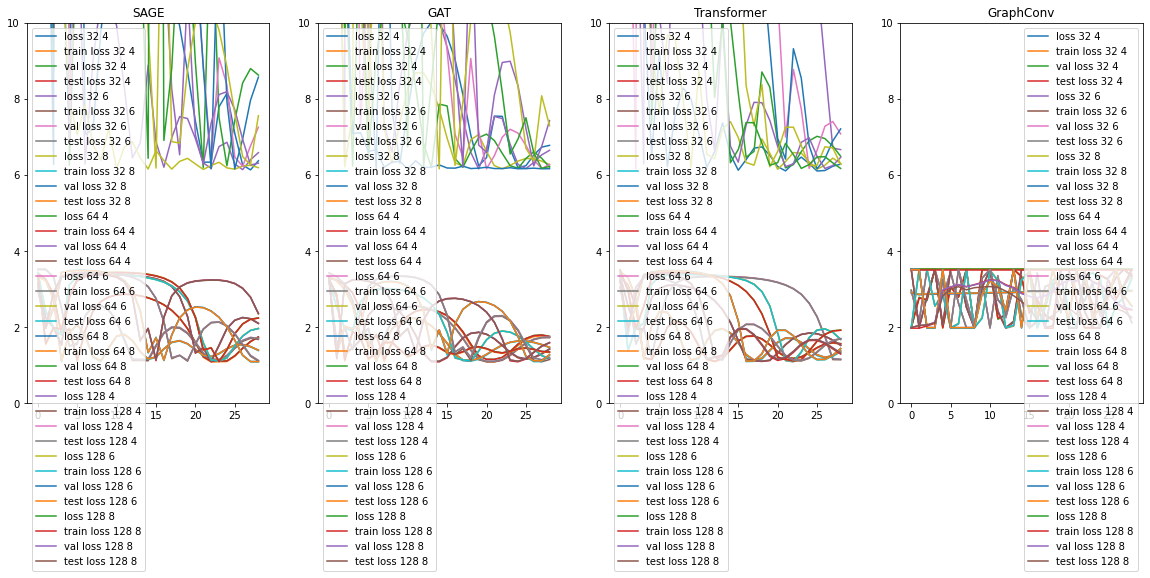

In [19]:
fig = plt.figure(figsize=(20, 7))

index = 1
for layer in layers:
    layer_models = list(filter(lambda x: x.get("layer_name")==layer, models))
    if not len(layer_models):
        continue
    model = layer_models[0]
    hidden_channels_nums = model.get("hidden_channels")
    layers_nums = model.get("num_layers")
    ax = fig.add_subplot(1, 4, index)
    ax.title.set_text(layer)
    ax.set_ylim(0.0, 10.0)
    legend = []
    hidden_channels_num = 32
    for hidden_channels_num in hidden_channels_nums:
        for layers_num in layers_nums:
            loss, train, val, test = losses[layer][hidden_channels_num][layers_num].values()
            ax.plot(loss)
            ax.plot(train)
            ax.plot(val)
            ax.plot(test)
            # legend += [f"loss {hidden_channels_num} {layers_num}"]
            legend += [f"loss {hidden_channels_num} {layers_num}", f"train loss {hidden_channels_num} {layers_num}", f"val loss {hidden_channels_num} {layers_num}", f"test loss {hidden_channels_num} {layers_num}"]
    ax.legend(legend)
    index += 1